In [ ]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
%matplotlib inline
import glob
from IPython.display import Image
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping

# Shared Input Layer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate

import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image


from google.colab import drive
drive.mount('/content/drive')
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


''

In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    dummies = pd.get_dummies(df[target])
    return df[result].values.astype(np.float32), dummies.values.astype(np.float32)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

path = "./drive/"

filename = os.path.join(path,"My Drive/breastCancerDataset.csv")
df = pd.read_csv(filename)
df = df.drop(columns=['Unnamed: 32', 'id'])

df.head()
# print(df.shape)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
x,y = to_xy(df,"diagnosis")

In [ ]:
# normalize data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x  = sc.fit_transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=50)

In [ ]:
print(x_train[0])
print(y_train[0])
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

[-1.0983657  -1.065715   -1.0614318  -0.9479084   0.17504703 -0.24164999
 -0.6652793  -0.7363962  -0.6521268   1.0281019  -0.24243806  2.3443985
 -0.23368374 -0.46219167  3.4398131   1.186639   -0.19177078  0.18878981
  1.9624041   1.120795   -1.1160071  -1.0091794  -1.0833471  -0.9202376
  0.15918623 -0.5767564  -0.962232   -1.1247313  -0.7551084   0.05176861]
[1. 0.]
(455, 30)
(455, 2)
(114, 30)
(114, 2)


In [ ]:
model = Sequential()
model.add(Dense(6, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 6)                 186       
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 56        
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 18        
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test), verbose=2,callbacks=[monitor], epochs=100, batch_size=6)

Epoch 1/100
76/76 - 0s - loss: 0.6767 - val_loss: 0.6348
Epoch 2/100
76/76 - 0s - loss: 0.6535 - val_loss: 0.6252
Epoch 3/100
76/76 - 0s - loss: 0.6357 - val_loss: 0.6035
Epoch 4/100
76/76 - 0s - loss: 0.6042 - val_loss: 0.5668
Epoch 5/100
76/76 - 0s - loss: 0.5584 - val_loss: 0.5157
Epoch 6/100
76/76 - 0s - loss: 0.5024 - val_loss: 0.4551
Epoch 7/100
76/76 - 0s - loss: 0.4357 - val_loss: 0.3895
Epoch 8/100
76/76 - 0s - loss: 0.3673 - val_loss: 0.3218
Epoch 9/100
76/76 - 0s - loss: 0.3042 - val_loss: 0.2636
Epoch 10/100
76/76 - 0s - loss: 0.2505 - val_loss: 0.2146
Epoch 11/100
76/76 - 0s - loss: 0.2086 - val_loss: 0.1749
Epoch 12/100
76/76 - 0s - loss: 0.1764 - val_loss: 0.1471
Epoch 13/100
76/76 - 0s - loss: 0.1526 - val_loss: 0.1243
Epoch 14/100
76/76 - 0s - loss: 0.1348 - val_loss: 0.1088
Epoch 15/100
76/76 - 0s - loss: 0.1218 - val_loss: 0.0962
Epoch 16/100
76/76 - 0s - loss: 0.1114 - val_loss: 0.0865
Epoch 17/100
76/76 - 0s - loss: 0.1039 - val_loss: 0.0776
Epoch 18/100
76/76 - 0s

In [ ]:
pred = model.predict(x_test)

In [ ]:
# Measure accuracy
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9912280701754386


[[75  0]
 [ 1 38]]
Plotting confusion matrix


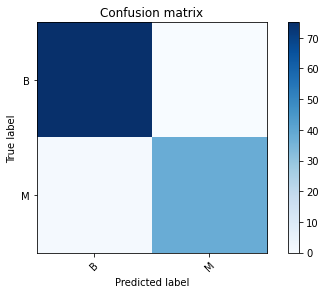

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        75
           1       1.00      0.97      0.99        39

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



In [ ]:
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')
label = encode_text_index(df,'diagnosis')
plt.figure()
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))